In [29]:
# This example shows a simulation for a direct arylation where all combinations have been measured.
# This allows us to access information about previously conducted experiments from .xlsx-files.

%load_ext autoreload
%autoreload 2

import os
import warnings
import sys
from pathlib import Path

import pandas as pd
import seaborn as sns

from baybe import Campaign
from baybe.objective import Objective
from baybe.parameters import (
    CategoricalParameter,
    NumericalDiscreteParameter,
    SubstanceParameter,
    TaskParameter,
)
from baybe.recommenders import RandomRecommender
from baybe.searchspace import SearchSpace
from baybe.simulation import simulate_scenarios
from baybe.targets import NumericalTarget
from baybe.utils.plotting import create_example_plots
from utils import backtest_plot

### Parameters for a full simulation loop

# For the full simulation, we need to define some additional parameters.
# These are the number of Monte Carlo runs and the number of experiments to be conducted per run.

N_DOE_ITERATIONS = 3
N_MC_ITERATIONS = 4
BATCH_SIZE = 2

# Let's define the path to the current directory.
script_path = Path(os.getcwd())
# Raise a warning if the path does not end with "scripts"
if script_path.name != "notebooks":
    warnings.warn(
        "Please run this script from the 'notebooks' directory to ensure that the data is loaded correctly."
    )
    raise SystemExit

results_dir = script_path.parent / "results"
data_dir = script_path.parent / "data"
figures_dir = script_path.parent / "figures"
if not data_dir.exists():
    raise FileNotFoundError(
        f"Data directory {data_dir} not found. Please make sure to run this script from the 'notebooks' directory."
    )
if not results_dir.exists():
    results_dir.mkdir(exist_ok=True)
if not figures_dir.exists():
    figures_dir.mkdir(exist_ok=True)
print(f"Current directory is {script_path}.")
print(f"Data is loaded from {data_dir}.")
print(f"Results will be saved in {results_dir}.")
print(f"Figures will be saved to {figures_dir}.")

warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current directory is /Users/m330808/source/baybe-paper/notebooks.
Data is loaded from /Users/m330808/source/baybe-paper/data.
Results will be saved in /Users/m330808/source/baybe-paper/results.
Figures will be saved to /Users/m330808/source/baybe-paper/figures.


In [30]:
### Lookup functionality and data creation

# We read the information about the conducted experiments from a .xlsx or .csv file.
# This data set was obtained from [Shields, B.J., Stevens et al. Nature 590, 89–96 (2021)](https://doi.org/10.1038/s41586-021-03213-y) and contains measurements of a reaction yield,
# varying typical reaction conditions.
try:
    lookup = pd.read_csv(data_dir / "direct_arylation.csv")
except FileNotFoundError:
    lookup = pd.read_excel(data_dir / "lookup.xlsx")

# print lookup header to screen
print(lookup.head())


   Concentration  Temp_C               Base                        Ligand  \
0            0.1     105  Potassium acetate                     BrettPhos   
1            0.1     105  Potassium acetate  Di-tert-butylphenylphosphine   
2            0.1     105  Potassium acetate                 (t-Bu)PhCPhos   
3            0.1     105  Potassium acetate        Tricyclohexylphosphine   
4            0.1     105  Potassium acetate                          PPh3   

  Solvent  yield  
0    DMAc   5.47  
1    DMAc   0.00  
2    DMAc  78.95  
3    DMAc   7.26  
4    DMAc  28.15  


In [31]:

dict_solvent = {
    "DMAc": r"CC(N(C)C)=O",
    "Butyornitrile": r"CCCC#N",
    "Butyl Ester": r"CCCCOC(C)=O",
    "p-Xylene": r"CC1=CC=C(C)C=C1",
}
dict_base = {
    "Potassium acetate": r"O=C([O-])C.[K+]",
    "Potassium pivalate": r"O=C([O-])C(C)(C)C.[K+]",
    "Cesium acetate": r"O=C([O-])C.[Cs+]",
    "Cesium pivalate": r"O=C([O-])C(C)(C)C.[Cs+]",
}
dict_ligand = {
    "BrettPhos": r"CC(C)C1=CC(C(C)C)=C(C(C(C)C)=C1)C2=C(P(C3CCCCC3)C4CCCCC4)C(OC)="
    "CC=C2OC",
    "Di-tert-butylphenylphosphine": r"CC(C)(C)P(C1=CC=CC=C1)C(C)(C)C",
    "(t-Bu)PhCPhos": r"CN(C)C1=CC=CC(N(C)C)=C1C2=CC=CC=C2P(C(C)(C)C)C3=CC=CC=C3",
    "Tricyclohexylphosphine": r"P(C1CCCCC1)(C2CCCCC2)C3CCCCC3",
    "PPh3": r"P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3",
    "XPhos": r"CC(C1=C(C2=CC=CC=C2P(C3CCCCC3)C4CCCCC4)C(C(C)C)=CC(C(C)C)=C1)C",
    "P(2-furyl)3": r"P(C1=CC=CO1)(C2=CC=CO2)C3=CC=CO3",
    "Methyldiphenylphosphine": r"CP(C1=CC=CC=C1)C2=CC=CC=C2",
    "1268824-69-6": r"CC(OC1=C(P(C2CCCCC2)C3CCCCC3)C(OC(C)C)=CC=C1)C",
    "JackiePhos": r"FC(F)(F)C1=CC(P(C2=C(C3=C(C(C)C)C=C(C(C)C)C=C3C(C)C)C(OC)=CC=C2OC)"
    r"C4=CC(C(F)(F)F)=CC(C(F)(F)F)=C4)=CC(C(F)(F)F)=C1",
    "SCHEMBL15068049": r"C[C@]1(O2)O[C@](C[C@]2(C)P3C4=CC=CC=C4)(C)O[C@]3(C)C1",
    "Me2PPh": r"CP(C)C1=CC=CC=C1",
}

### Creating the Objective
objective = Objective(
    mode="SINGLE", targets=[NumericalTarget(name="yield", mode="MAX")]
)
### Define the substance encoding
encoding = "RDKIT"

In [32]:

temperatures = [90, 105, 120]
concentrations = [0.057, 0.1, 0.153]
# sample_fractions = [0.01, 0.1, 0.5]
sample_fractions = [0.01, 0.1]




Temperature: 90
Taking additional data from [105, 120] into account.

Fraction of data used:  0.01


100%|##########| 16/16 [00:12<00:00,  1.26it/s]


Fraction of data used:  0.1


100%|##########| 16/16 [00:39<00:00,  2.48s/it]


Fraction of data used: 0.0


100%|##########| 4/4 [00:01<00:00,  2.64it/s]


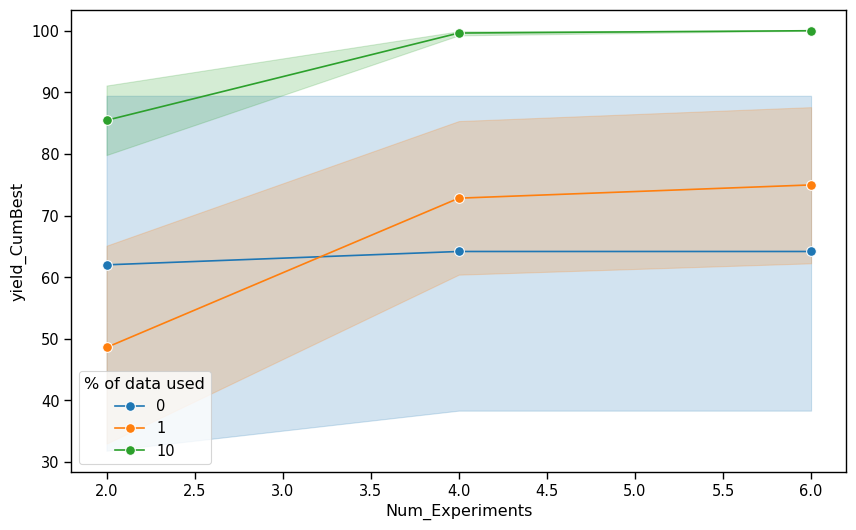



Temperature: 105
Taking additional data from [90, 120] into account.

Fraction of data used:  0.01


100%|##########| 16/16 [00:11<00:00,  1.45it/s]


Fraction of data used:  0.1


100%|##########| 16/16 [00:39<00:00,  2.47s/it]


Fraction of data used: 0.0


100%|##########| 4/4 [00:01<00:00,  2.53it/s]


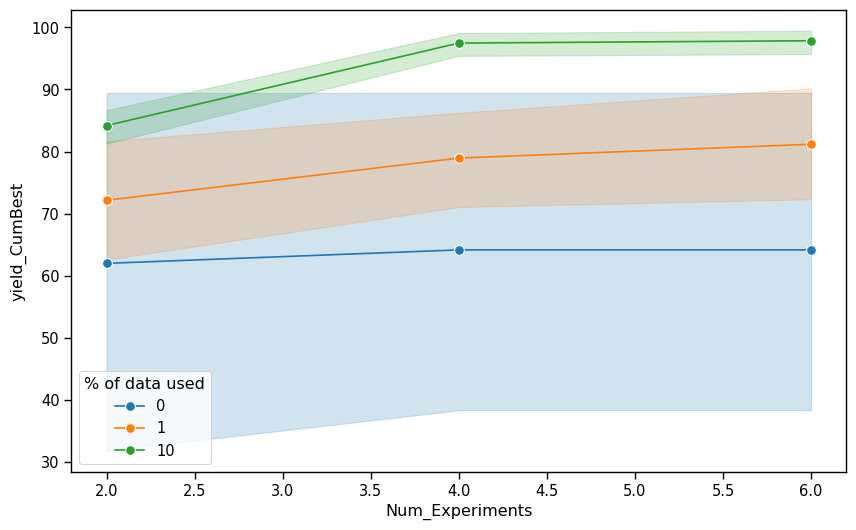



Temperature: 120
Taking additional data from [90, 105] into account.

Fraction of data used:  0.01


100%|##########| 16/16 [00:12<00:00,  1.33it/s]


Fraction of data used:  0.1


100%|##########| 16/16 [00:48<00:00,  3.01s/it]


Fraction of data used: 0.0


100%|##########| 4/4 [00:01<00:00,  2.53it/s]


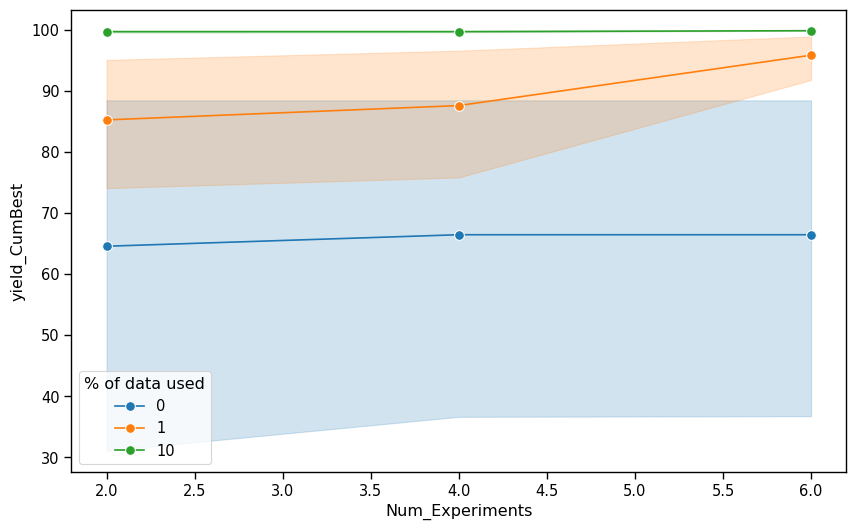

In [33]:
### DEV PRINTS
# print(lookup.dtypes)
for temp in temperatures:
    print(f"\n\nTemperature: {temp}")
    excluded_temps = [t for t in temperatures if t != temp]
    print(f"Taking additional data from {excluded_temps} into account.\n")
    campaign = Campaign(
        searchspace=SearchSpace.from_product(
            parameters=[
                SubstanceParameter(
                    name="Solvent", data=dict_solvent, encoding=encoding
                ),
                SubstanceParameter(name="Base", data=dict_base, encoding=encoding),
                SubstanceParameter(name="Ligand", data=dict_ligand, encoding=encoding),
                ### FOR TRANSFER LEARNING ###
                NumericalDiscreteParameter(
                    name="Temp_C", values=temperatures, tolerance=2
                ),
                # NOTE: "Original" transfer learning:
                # TaskParameter(
                #     name="Temp_C",
                #     values=[str(t) for t in temperatures],
                #     active_values=[str(temp)],
                # ),
                #############################
                NumericalDiscreteParameter(
                    name="Concentration", values=concentrations, tolerance=0.001
                ),
            ]
        ),
        objective=objective,
    )

    # > Change searchspace.discrete.metadata such that the other temperatures are not suggested

    ### DEV PRINTS
    # print(campaign.searchspace.discrete)
    # print("### METADATA ###")
    # print(campaign.searchspace.discrete.metadata)
    # campaign.searchspace.discrete.exp_rep.to_csv("exp_rep_before.csv")

    dont_recommend_indices: list = []
    for excluded_temp in excluded_temps:
        indices = campaign.searchspace.discrete.exp_rep.index[
            campaign.searchspace.discrete.exp_rep["Temp_C"] == excluded_temp
        ].tolist()
        dont_recommend_indices.extend(indices)
    dont_recommend_indices.sort()

    ### DEV PRINTS
    # print(dont_recommend_indices)
    # campaign.searchspace.discrete.metadata.to_csv("metadata_before.csv")

    campaign.searchspace.discrete.metadata.loc[indices, "dont_recommend"] = True

    ### DEV PRINTS
    # campaign.searchspace.discrete.metadata.to_csv("metadata_after.csv")
    # continue

    # We can now create a lookup table that contains all data except the data for the current temperature.
    lookup_other_data = lookup[lookup["Temp_C"] != temp].copy(deep=True)
    # DEV: Print full lookup table to a file
    path_to_lookup = results_dir / f".lookup_T{temp}_numTL.csv"
    lookup_other_data.to_csv(path_to_lookup, index=False)

    # We can now use the `simulate_scenarios` function to simulate a full optimization loop.
    results: list[pd.DataFrame] = []
    for p in sample_fractions:
        print("Fraction of data used: ", p)
        result_fraction = simulate_scenarios(
            {f"{int(100*p)}": campaign},
            lookup,
            initial_data=[
                lookup_other_data.sample(frac=p) for _ in range(N_MC_ITERATIONS)
            ],
            batch_size=BATCH_SIZE,
            n_doe_iterations=N_DOE_ITERATIONS,
            n_mc_iterations=N_MC_ITERATIONS,
        )
        results.append(result_fraction)
    print("Fraction of data used: 0.0")
    result_baseline = simulate_scenarios(
        {"0": campaign},
        lookup,
        batch_size=BATCH_SIZE,
        n_doe_iterations=N_DOE_ITERATIONS,
        n_mc_iterations=N_MC_ITERATIONS,
    )
    results = pd.concat([result_baseline, *results])
    # Rename the column for more reasonable plotting
    results.rename(columns={"Scenario": "% of data used"}, inplace=True)

    # first, print the results to a file
    path_to_results = results_dir / f".results_T{temp}_numTL.csv"
    results.to_csv(path_to_results, index=False)

    # Let's visualize the results. As you can see, the amount of initial data used has a significant impact on the performance.
    backtest_plot(
        df=results,
        figure_name=f"transfer_learning_numTL_T{temp}_bq{BATCH_SIZE}_ndi{N_DOE_ITERATIONS}_mc{N_MC_ITERATIONS}",
        y="yield_CumBest",
        hue="% of data used",
        path=figures_dir,
        # indicator_y=90,
        # indicator_labels=["MORDRED", "OneHot"],
    )

Concentration    float64
Temp_C             int64
Base              object
Ligand            object
Solvent           object
yield            float64
dtype: object


Concentration: 0.057
Taking additional data from [0.1, 0.153] into account.

Fraction of data used:  0.01


100%|##########| 16/16 [00:12<00:00,  1.28it/s]


Fraction of data used:  0.1


100%|##########| 16/16 [00:43<00:00,  2.74s/it]


Fraction of data used: 0.0


100%|##########| 4/4 [00:01<00:00,  2.80it/s]


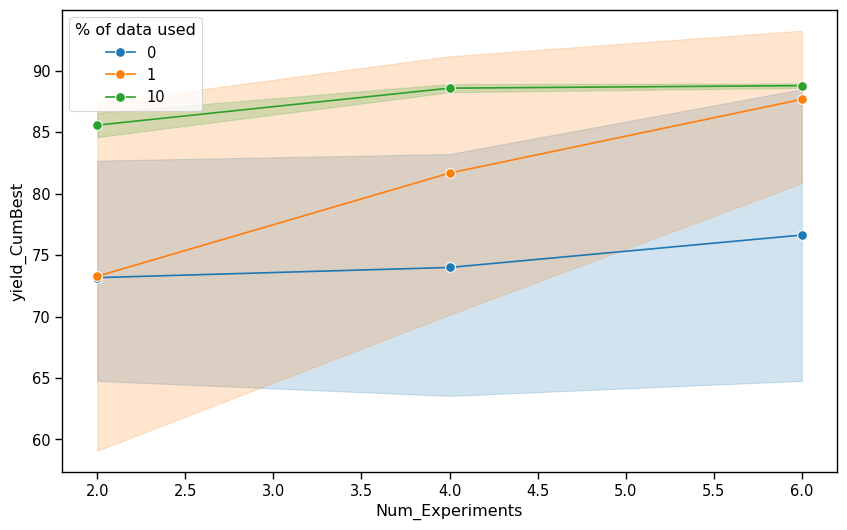



Concentration: 0.1
Taking additional data from [0.057, 0.153] into account.

Fraction of data used:  0.01


100%|##########| 16/16 [00:11<00:00,  1.38it/s]


Fraction of data used:  0.1


100%|##########| 16/16 [00:43<00:00,  2.73s/it]


Fraction of data used: 0.0


100%|##########| 4/4 [00:01<00:00,  2.25it/s]


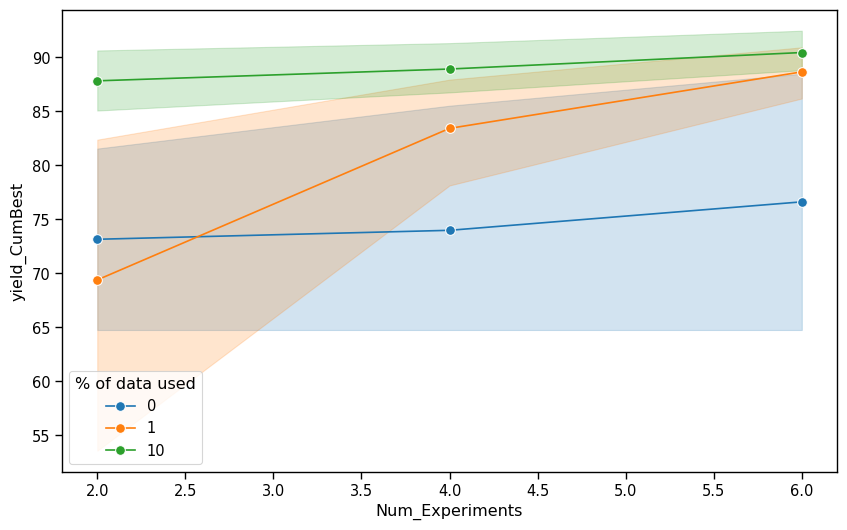



Concentration: 0.153
Taking additional data from [0.057, 0.1] into account.

Fraction of data used:  0.01


100%|##########| 16/16 [00:12<00:00,  1.31it/s]


Fraction of data used:  0.1


100%|##########| 16/16 [00:41<00:00,  2.60s/it]


Fraction of data used: 0.0


100%|##########| 4/4 [00:01<00:00,  2.49it/s]


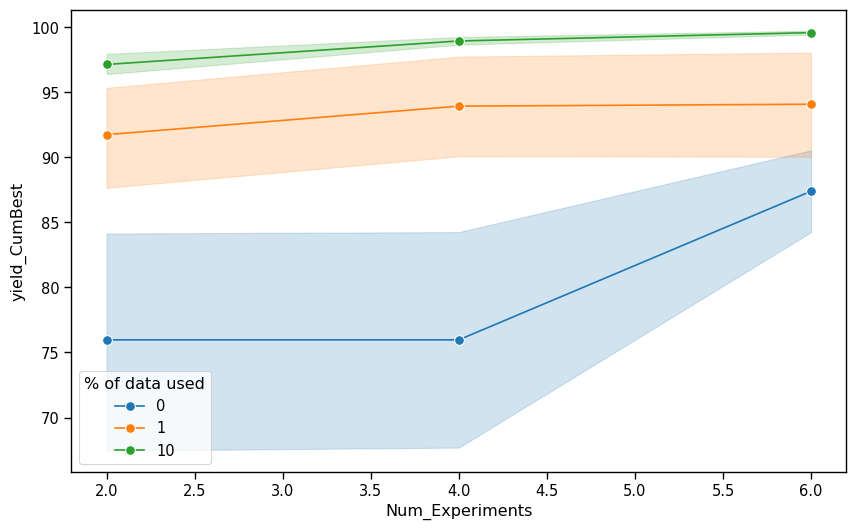

In [36]:
print(lookup.dtypes)
for conc in concentrations:
    print(f"\n\nConcentration: {conc}")
    excluded_concs = [c for c in concentrations if c != conc]
    print(f"Taking additional data from {excluded_concs} into account.\n")
    campaign = Campaign(
        searchspace=SearchSpace.from_product(
            parameters=[
                SubstanceParameter(
                    name="Solvent", data=dict_solvent, encoding=encoding
                ),
                SubstanceParameter(name="Base", data=dict_base, encoding=encoding),
                SubstanceParameter(name="Ligand", data=dict_ligand, encoding=encoding),
                ### FOR TRANSFER LEARNING ###
                NumericalDiscreteParameter(
                    name="Concentration", values=concentrations, tolerance=0.001
                ),
                # NOTE: "Original" transfer learning:
                # TaskParameter(
                #     name="Concentration",
                #     values=[str(c) for c in concentrations],
                #     active_values=[str(conc)],
                # ),
                #############################
                NumericalDiscreteParameter(
                    name="Temp_C",
                    values=temperatures,
                    tolerance=2,
                ),
            ]
        ),
        objective=objective,
    )

    dont_recommend_indices: list = []
    for excluded_conc in excluded_concs:
        indices = campaign.searchspace.discrete.exp_rep.index[
            campaign.searchspace.discrete.exp_rep["Concentration"] == excluded_conc
        ].tolist()
        dont_recommend_indices.extend(indices)
    dont_recommend_indices.sort()
    campaign.searchspace.discrete.metadata.loc[indices, "dont_recommend"] = True

    # We can now create a lookup table that contains all data except the data for the current concentration.
    lookup_other_data = lookup[lookup["Concentration"] != conc].copy(deep=True)
    # DEV: Print full lookup table to a file
    path_to_lookup = results_dir / f".lookup_c{conc}_numTL.csv"
    lookup_other_data.to_csv(path_to_lookup, index=False)

    # We can now use the `simulate_scenarios` function to simulate a full optimization loop.
    results: list[pd.DataFrame] = []
    for p in sample_fractions:
        print("Fraction of data used: ", p)
        result_fraction = simulate_scenarios(
            {f"{int(100*p)}": campaign},
            lookup,
            initial_data=[
                lookup_other_data.sample(frac=p) for _ in range(N_MC_ITERATIONS)
            ],
            batch_size=BATCH_SIZE,
            n_doe_iterations=N_DOE_ITERATIONS,
            n_mc_iterations=N_MC_ITERATIONS,
        )
        results.append(result_fraction)
    print("Fraction of data used: 0.0")
    result_baseline = simulate_scenarios(
        {"0": campaign},
        lookup,
        batch_size=BATCH_SIZE,
        n_doe_iterations=N_DOE_ITERATIONS,
        n_mc_iterations=N_MC_ITERATIONS,
    )
    results = pd.concat([result_baseline, *results])
    # Rename the column for more reasonable plotting
    results.rename(columns={"Scenario": "% of data used"}, inplace=True)

    # first, print the results to a file
    path_to_results = results_dir / f".results_c{conc}_numTL.csv"
    results.to_csv(path_to_results, index=False)

    # Let's visualize the results. As you can see, the amount of initial data used has a significant impact on the performance.
    backtest_plot(
        df=results,
        figure_name=f"transfer_learning_numTL_c{conc}_bq{BATCH_SIZE}_ndi{N_DOE_ITERATIONS}_mc{N_MC_ITERATIONS}",
        y="yield_CumBest",
        hue="% of data used",
        path=figures_dir,
        # indicator_y=90,
        # indicator_labels=["MORDRED", "OneHot"],
    )